Ash Rai <br>
CSC 675: Neural Networks and Deep Learning

# Homework 4

### Preprocessing
Importing Dataset

In [1]:
import os

data_dir = '/home/csuser/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


Parsing Dataset

In [2]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

Plotting the temperature timeseries

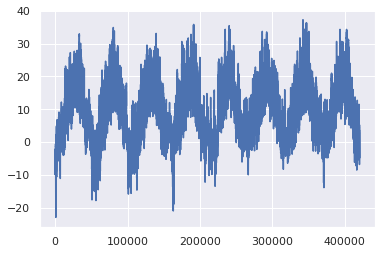

In [3]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")
temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)

Plotting the first 10 days of the temperature timeseries

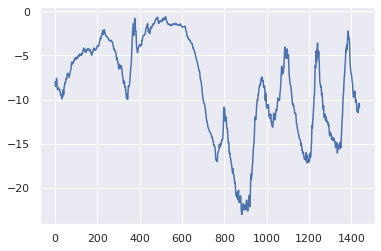

In [4]:
plt.plot(range(1440), temp[:1440])

Normalizing the data

In [3]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

Generator yielding timeseries samples and their targets

In [4]:
def generator(data, lookback, delay, min_index, max_index,
            shuffle=False, batch_size=128, step=6): 
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
   
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

Preparing the training, validation, and test generators

In [5]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=0,
                    max_index=200000,
                    shuffle=True,
                    step=step,
                    batch_size=batch_size)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=300001,
                    max_index=None,
                    step=step,
                    batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

Computing the common-sense baseline MAE

In [9]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


Converting the MAE back to a Celsius error

In [10]:
celsius_mae = 0.29 * std[1]

Training and evaluating a densely connected model

### A basic machine-learning approach

Training and evaluating a densely connected model

In [10]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                            steps_per_epoch=500,
                            epochs=20,
                            validation_data=val_gen,
                            validation_steps=val_steps)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
500/500 [==============================] - 10s 19ms/step - loss: 1.3234 - val_loss: 0.7410
Epoch 2/20
500/500 [==============================] - 10s 20ms/step - loss: 0.4414 - val_loss: 0.3726
Epoch 3/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2986 - val_loss: 0.3138
Epoch 4/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2722 - val_loss: 0.3026
Epoch 5/20
500/500 [==============================] - 10s 21ms/step - loss: 0.2580 - val_loss: 0.3249
Epoch 6/20
500/500 [==============================] - 10s 19ms/step - loss: 0.2471 - val_loss: 0.3184
Epoch 7/20
500/500 [==============================] - 10s 21ms/step - loss: 0.2386 - val_loss: 0.3299
Epoch 8/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2351 - val_loss: 0.3281
Epoch 9/20
500/500 [==============================] - 10s 21ms/step - loss: 0.2277 - val_loss: 0.3457
Epoch 

Plotting results

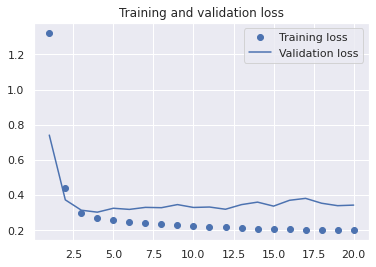

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### A first recurrent baseline

Training and evaluating a GRU-based model

In [15]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 11s 23ms/step - loss: 0.3016 - val_loss: 0.2706
Epoch 2/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2873 - val_loss: 0.2722
Epoch 3/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2816 - val_loss: 0.2669
Epoch 4/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2735 - val_loss: 0.2651
Epoch 5/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2696 - val_loss: 0.2655
Epoch 6/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2652 - val_loss: 0.2650
Epoch 7/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2613 - val_loss: 0.2654
Epoch 8/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2555 - val_loss: 0.2693
Epoch 9/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2516 - val_loss: 0.2691
Epoch 10/20
500/500 [==============================] - 11s 21ms/step - loss: 0.247

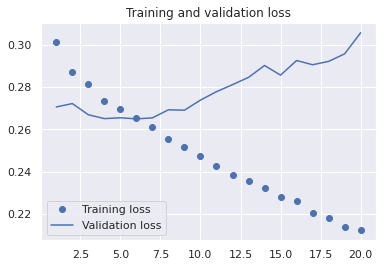

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Using recurrent dropout to fight overfitting

Training and evaluating a dropout-regularized GRU-based model


In [8]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/40
500/500 [==============================] - 258s 516ms/step - loss: 0.3237 - val_loss: 0.2845
Epoch 2/40
500/500 [==============================] - 255s 510ms/step - loss: 0.3032 - val_loss: 0.2821
Epoch 3/40
500/500 [==============================] - 256s 512ms/step - loss: 0.2991 - val_loss: 0.2771
Epoch 4/40
500/500 [==============================] - 254s 508ms/step - loss: 0.2926 - val_loss: 0.2740
Epoch 5/40
500/500 [==============================] - 254s 509ms/step - loss: 0.2881 - val_loss: 0.2744
Epoch 6/40
500/500 [==============================] - 259s 517ms/step - loss: 0.2858 - val_loss: 0.2746
Epoch 7/40
500/500 [==============================] - 256s 512ms/step - loss: 0.2823 - val_loss: 0.2735
Epoch 8/40
500/500 [==============================] - 253s 506ms/step - loss: 0.2816 - val_loss: 0.2787
Epoch 9/40
500/500 [==============================] - 254s 509ms/step - loss: 0.2780 - val_l

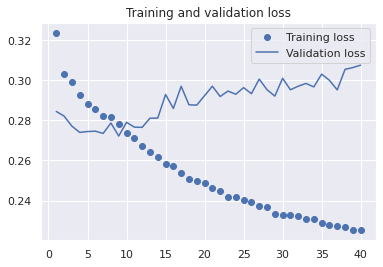

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Stacking recurrent layers

Training and evaluating a dropout-regularized, stacked GRU model

In [15]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 470s 939ms/step - loss: 0.3156 - val_loss: 0.2830
Epoch 2/20
500/500 [==============================] - 472s 944ms/step - loss: 0.2996 - val_loss: 0.2666
Epoch 3/20
500/500 [==============================] - 473s 946ms/step - loss: 0.2929 - val_loss: 0.2663
Epoch 4/20
500/500 [==============================] - 473s 946ms/step - loss: 0.2872 - val_loss: 0.2818
Epoch 5/20
500/500 [==============================] - 476s 951ms/step - loss: 0.2800 - val_loss: 0.2894
Epoch 6/20
500/500 [==============================] - 475s 951ms/step - loss: 0.2739 - val_loss: 0.2947
Epoch 7/20
500/500 [==============================] - 476s 952ms/step - loss: 0.2688 - val_loss: 0.2842
Epoch 8/20
500/500 [==============================] - 477s 954ms/step - loss: 0.2634 - val_loss: 0.2986
Epoch 9/20
500/500 [==============================] - 477s 954ms/step - loss: 0.2582 - val_loss: 0.2975
Epoch 10/20
500/500 [==============================] - 485s 970m

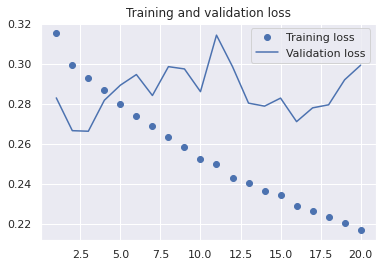

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Using bidirectional RNNs
Training and evaluating an LSTM using reversed sequences



In [17]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

max_features = 10000
maxlen = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

17465344/17464789 [==============================] - 0s 0us/step
Epoch 1/10
157/157 [==============================] - 6s 39ms/step - loss: 0.4874 - acc: 0.7638 - val_loss: 0.4189 - val_acc: 0.8406
Epoch 2/10
157/157 [==============================] - 6s 37ms/step - loss: 0.3120 - acc: 0.8787 - val_loss: 0.5112 - val_acc: 0.8356
Epoch 3/10
157/157 [==============================] - 6s 37ms/step - loss: 0.2480 - acc: 0.9079 - val_loss: 0.5587 - val_acc: 0.8340
Epoch 4/10
157/157 [==============================] - 6s 37ms/step - loss: 0.2174 - acc: 0.9230 - val_loss: 0.4463 - val_acc: 0.8360
Epoch 5/10
157/157 [==============================] - 6s 37ms/step - loss: 0.1940 - acc: 0.9319 - val_loss: 0.3895 - val_acc: 0.8436
Epoch 6/10
157/157 [==============================] - 6s 37ms/step - loss: 0.1656 - acc: 0.9453 - val_loss: 0.3717 - val_acc: 0.8784
Epoch 7/10
157/157 [==============================] - 6s 38ms/step - loss: 0.1529 - acc: 0.9485 - val_loss: 0.3984 - val_acc: 0.8654
Epoc

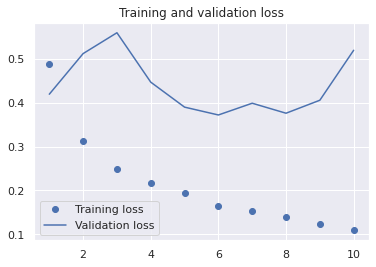

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Training and evaluating a bidirectional LSTM

In [19]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 7s 41ms/step - loss: 0.5441 - acc: 0.7315 - val_loss: 0.3925 - val_acc: 0.8322
Epoch 2/10
157/157 [==============================] - 6s 37ms/step - loss: 0.3409 - acc: 0.8709 - val_loss: 0.5993 - val_acc: 0.8128
Epoch 3/10
157/157 [==============================] - 6s 37ms/step - loss: 0.2735 - acc: 0.9012 - val_loss: 0.3086 - val_acc: 0.8736
Epoch 4/10
157/157 [==============================] - 6s 37ms/step - loss: 0.2328 - acc: 0.9169 - val_loss: 0.3030 - val_acc: 0.8902
Epoch 5/10
157/157 [==============================] - 6s 37ms/step - loss: 0.1969 - acc: 0.9298 - val_loss: 0.4274 - val_acc: 0.8158
Epoch 6/10
157/157 [==============================] - 6s 37ms/step - loss: 0.1849 - acc: 0.9354 - val_loss: 0.3923 - val_acc: 0.8672
Epoch 7/10
157/157 [==============================] - 6s 37ms/step - loss: 0.1675 - acc: 0.9436 - val_loss: 0.4164 - val_acc: 0.8614
Epoch 8/10
157/157 [==============================] - 6s 37ms/step - 

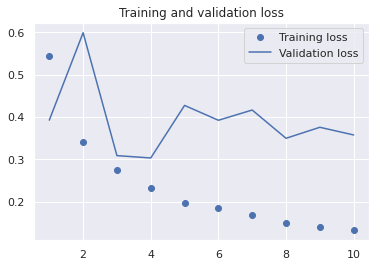

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Training a bidirectional GRU

In [21]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 8s 17ms/step - loss: 0.2997 - val_loss: 0.2722
Epoch 2/40
500/500 [==============================] - 8s 16ms/step - loss: 0.2755 - val_loss: 0.2573
Epoch 3/40
500/500 [==============================] - 8s 17ms/step - loss: 0.2678 - val_loss: 0.2550
Epoch 4/40
500/500 [==============================] - 9s 18ms/step - loss: 0.2618 - val_loss: 0.2586
Epoch 5/40
500/500 [==============================] - 9s 18ms/step - loss: 0.2557 - val_loss: 0.2633
Epoch 6/40
500/500 [==============================] - 9s 18ms/step - loss: 0.2483 - val_loss: 0.2771
Epoch 7/40
500/500 [==============================] - 9s 18ms/step - loss: 0.2429 - val_loss: 0.2746
Epoch 8/40
500/500 [==============================] - 9s 18ms/step - loss: 0.2358 - val_loss: 0.2939
Epoch 9/40
500/500 [==============================] - 9s 18ms/step - loss: 0.2280 - val_loss: 0.3057
Epoch 10/40
500/500 [==============================] - 9s 17ms/step - loss: 0.2218 - val_lo

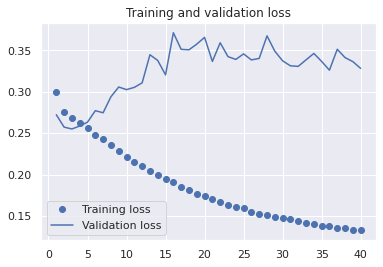

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Going even further

For this section I decided to use LSTM layer instead of the GRU layer. The model is a dropout-regularized, stacked LSTM model. For my GRU based model that was similar in the architecture, the overfitting started happening around the 7th epoch despite the dropout. Hence, while I realize it might be different with the LSTM replacing the GRU layer, I figured it could be likely that they would perhaps follow a similar trend. Hence, I tried to run this model only for 10 epochs.

In [11]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.LSTM(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
500/500 [==============================] - 290s 580ms/step - loss: 0.3195 - val_loss: 0.2728
Epoch 2/10
500/500 [==============================] - 290s 580ms/step - loss: 0.2915 - val_loss: 0.2654
Epoch 3/10
500/500 [==============================] - 292s 585ms/step - loss: 0.2833 - val_loss: 0.2766
Epoch 4/10
500/500 [==============================] - 292s 584ms/step - loss: 0.2778 - val_loss: 0.2715
Epoch 5/10
500/500 [==============================] - 294s 587ms/step - loss: 0.2727 - val_loss: 0.2848
Epoch 6/10
500/500 [==============================] - 294s 588ms/step - loss: 0.2677 - val_loss: 0.2801
Epoch 7/10
500/500 [==============================] - 293s 586ms/step - loss: 0.2616 - val_loss: 0.2768
Epoch 8/10
500/500 [==============================] - 293s 587ms/step - loss: 0.2586 - val_loss: 0.2891
Epoch 9/10
500/500 [==============================] - 293s 587ms/step - loss: 0.2554 - val_l

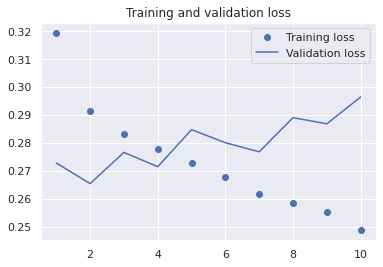

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Saving the model

In [20]:
from keras.models import load_model

model.save('LSTM_model.h5')

Running the test generator on the mode

In [23]:
results = model.evaluate(test_gen, steps=test_steps)

929/929 [==============================] - 46s 50ms/step - loss: 0.3057


The result of the model on the test generator produced the loss of 0.3057. This seems close to the validation accuracy of the model, which hovered around 0.28. 


This also is in line with the examples and the results from the book. The results of the different examples in the book also lies in the validaiton loss value of 0.28. This also was the best validation loss I was able to produce. Perhaps stacking more layers or making the RNN larger would have helped a better result, but I was unable to run other models due to time constraints. I would like to try it some other time and see how making the model more complicated affects the results of this weather-forecasting problem in the near-future.